In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import tensorflow as tf
import keras
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
import sklearn
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import random
import pandas as pd
# from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from tensorflow.keras.models import Model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2826240/45929032 bytes (6.2%)6127616/45929032 bytes (13.3%)9527296/45929032 bytes (20.7%)12541952/45929032 bytes (27.3%)15949824/45929032 bytes (34.7%)19374080/45929032 bytes (42.2%)22765568/45929032 bytes (49.6%)25829376/45929032 bytes (56.2%)28917760/45929032 bytes (63.0%)32227328/45929032 bytes (70.2%)35561472/45929032 bytes (77.4%)38879232/45929032 bytes (84.7%)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
mainPath="/content/gdrive/MyDrive/hand sign database"

Mounted at /content/gdrive


In [4]:
nCategories=8

In [5]:
partition ={}
labels ={}
partition['train']=list()
partition['validation']=list()
partition['test']=list()
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [6]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

help
39   8   5
thief
37   8   5
call
39   8   5
hot
39   8   5
pain
39   8   5
accident
39   8   5
lose
30   6   4
doctor
39   8   5


In [7]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [ ]:
import pickle
with tf.device("/device:GPU:0"):
  with open('/content/gdrive/MyDrive/inception model and history/PARTITION', 'wb') as file_pi:
    pickle.dump(partition, file_pi)

In [8]:
from keras.utils import np_utils


In [9]:
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      try:
        vidObj = moviepy.editor.VideoFileClip(ID)
      except IOError as e:
        errno, strerror = e.args
        print(errno)
        print(strerror)
      video_duration = int(vidObj.duration)   
      nFrames=self.dim[0]
      array=np.empty(shape=(nFrames,self.dim[1],self.dim[2],3))
      frameSize=(self.dim[1],self.dim[2])
      for k in range(nFrames):
        frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
        frameR=Image.fromarray(frame).convert("RGB")
        frame2=frameR.resize(frameSize)
        arrayi=np.array(frame2)/255
        # if k is 0:
        #   print(np.shape(arrayi))
        array[k]=arrayi
        del arrayi
      # print(np.shape(array))
      X[i,]=array
      del array
      #######
      # Store class
      y[i] = self.labels[ID]
    print("Shape of X output by data generator: ",np.shape(X))
    return np.array(X), tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [10]:
def createModel4(Tframes=20,frameSize=(224,224),batch_size=10,epochs=500,verbose=2,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nLstmUnits=147):
  input=Input(shape=(Tframes,frameSize[0],frameSize[1],3))
  inc=InceptionV3(include_top=False,input_shape=(224,224,3))
  branchOutputs=[]
  for i in range(Tframes):
    out=Lambda(lambda x: x[:,i,:,:,:])(input)
    print("out.shape: ",out.shape)
    name="inception_"+str(i)
    tempModel=Sequential(name=name)
    # tempModel.add(InceptionV3(include_top=False,input_shape=(224,224,3)))
    tempModel.add(inc)
    out1=tempModel(out)
    branchOutputs.append(out1)
  out = Concatenate()(branchOutputs)
  '''
  model=Model(inputs=input,outputs=out)
  model2=Sequential()
  model2.add(model)
  model2.add(tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512))))
  model2.add(tfKL.Flatten())
  model2.add(Dense(units=8,activation='softmax'))
  model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  '''
  out=tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512)))(out)
  out=tfKL.Flatten()(out)
  out=Dense(units=8,activation='softmax')(out)
  model=Model(inputs=input,outputs=out)
  model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
  for layer in model.layers:
    print(layer.name)
  return model

In [11]:
def getLabels(partition=partition):
  labels={}
  for category in os.listdir(mainPath):
    print(category)
    vidL=[]
    for video in os.listdir(os.path.join(mainPath,category)):
      vidL.append(os.path.join(mainPath,category,video))
      lenVidL=len(vidL)
      random.shuffle(vidL)
      for i in range(lenVidL):
        labels[vidL[i]]=mappingCatToN[category]
  return  labels
labels=getLabels()
print(labels)

help
thief
call
hot
pain
accident
lose
doctor
{'/content/gdrive/MyDrive/hand sign database/help/help_Crop_001_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_001_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_005_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_004_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_007_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_002_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_006_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_003_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_010_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_010_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_007_01.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help_Crop_008_02.avi': 3, '/content/gdrive/MyDrive/hand sign database/help/help

In [12]:
import gc
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
  def on_batch_end(self, epoch, logs=None):
    print("Batch end")
    gc.enable()
    gc.collect()
    return

87916544/87910968 [==============================] - 0s 0us/step
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
input_1
lambda
lambda_1
lambda_2
lambda_3
lambda_4
lambda_5
lambda_6
lambda_7
lambda_8
lambda_9
lambda_10
lambda_11
lambda_12
lambda_13
lambda_14
lambda_15
lambda_16
inception_0
inception_1
inception_2
inception_3
inception_4
inception_5
inception_6
inception_7
inception_8
inception_9
inception_10
inception_11
inception_12
inception_13
inception_14
inception_15
inception_16
concatenate_2


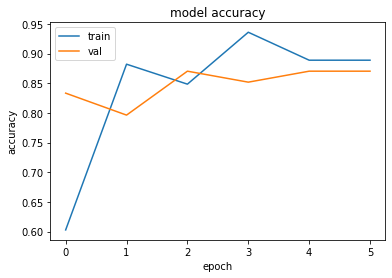

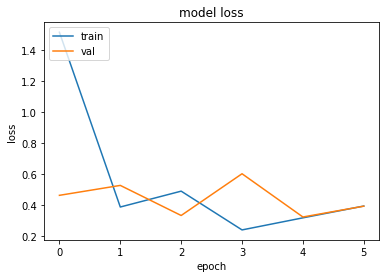

Time taken:  1499.5755701065063


In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=17
  batch_size=9
  # nLstmUnits=1800 #1700 #1600 was good
  # nLstmUnits=1660 #1640#1630 #1650
  nLstmUnits=1750
  frameSize=(224,224)
  params = {'dim': (Tframes,frameSize[0],frameSize[1],3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}
  epochs=6
  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes,nLstmUnits=nLstmUnits,optimizer=keras.optimizers.Adam(learning_rate=0.00068))
  begin=time.time()
  history=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

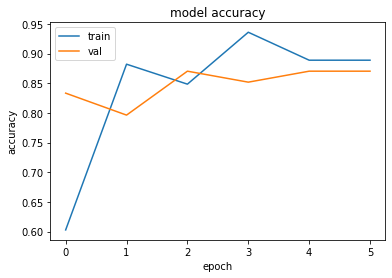

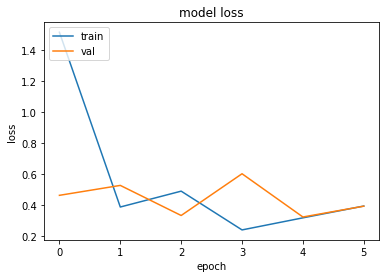

{'loss': [1.5123074054718018, 0.3882955312728882, 0.49027711153030396, 0.2409830540418625, 0.3186520040035248, 0.3945123553276062], 'val_loss': [0.4634570777416229, 0.5272704362869263, 0.3337526321411133, 0.6022081971168518, 0.32412847876548767, 0.39367273449897766], 'accuracy': [0.6026936173439026, 0.8821548819541931, 0.8484848737716675, 0.936026930809021, 0.8888888955116272, 0.8888888955116272], 'val_accuracy': [0.8333333134651184, 0.7962962985038757, 0.8703703880310059, 0.8518518805503845, 0.8703703880310059, 0.8703703880310059]}


In [ ]:
HIST={}
HIST['loss']=list()
HIST['val_loss']=list()
HIST['accuracy']=list()
HIST['val_accuracy']=list()
# with tf.device("/device:GPU:0"):
#   with open('/content/gdrive/MyDrive/vgg16 models and history/HISTORY', 'rb') as file_pi:
#     prevh=pickle.load(file_pi)

# for loss in prevh['loss']:
#   HIST['loss'].append(loss)

# for loss in prevh['val_loss']:
#   HIST['val_loss'].append(loss)

# for acc in prevh['accuracy']:
#   HIST['accuracy'].append(acc)

# for acc in prevh['val_accuracy']:
#   HIST['val_accuracy'].append(acc)
#######################
#######################
for loss in history.history['loss']:
  HIST['loss'].append(loss)

for loss in history.history['val_loss']:
  HIST['val_loss'].append(loss)

for acc in history.history['accuracy']:
  HIST['accuracy'].append(acc)

for acc in history.history['val_accuracy']:
  HIST['val_accuracy'].append(acc)


plt.plot(HIST['accuracy'])
plt.plot(HIST['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(HIST['loss'])
plt.plot(HIST['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(HIST)

In [ ]:
with open("/content/gdrive/MyDrive/inception model and history/HISTORY",'wb') as f:
  pickle.dump(HIST,f)

In [13]:
with tf.device("/device:GPU:0"):
  loadedModel=keras.models.load_model("/content/gdrive/MyDrive/inception model and history/MODEL2")
  loadedModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17, 224, 224 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [14]:
def testAccuracy(Result,testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

In [17]:
with tf.device('/device:GPU:0'):
  Tframes=17
  frameSize=(224,224)
  params = {'dim': (Tframes,frameSize[0],frameSize[1],3),
            'batch_size': 1,
            'n_classes': 8,
            'shuffle': True}
  params1 = params
  params1['shuffle']=False
  params1['batch_size']=1
  testing_generator = DataGenerator(partition['test'], labels, **params1)
  res=loadedModel.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())

Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 3)
Shape of X output by data generator:  (1, 17, 224, 224, 

In [18]:
res2=np.argmax(res,axis=1)
print("Our prediction: ")
print(res2)
testY=[]
for el in partition['test']:
  testY.append(labels[el])
print("Truth: ")
print(testY)

Our prediction: 
[3 3 3 3 3 7 7 7 7 7 1 1 1 1 1 4 4 4 4 4 6 6 6 6 6 0 0 0 0 0 5 5 5 5 2 2 2
 2 2]
Truth: 
[3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 5, 5, 5, 5, 2, 2, 2, 2, 2]


In [19]:
print(testAccuracy(res2,testY))

1.0


In [20]:
gc.collect()

0

In [ ]:
# with tf.device("/device:GPU:0"):
#   model.save("/content/gdrive/MyDrive/inception model and history/MODEL2")

In [ ]:
# with tf.device('/device:GPU:0'):
#   batch_size=10
#   nLstmUnits=1600
#   params = {'dim': (Tframes,224,224,3),
#             'batch_size': batch_size,
#             'n_classes': 8,
#             'shuffle': True}
#   epochs=1
#   # Generators
#   training_generator = DataGenerator(partition['train'], labels, **params)
#   validation_generator = DataGenerator(partition['validation'], labels, **params)


#   begin=time.time()
#   history=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
#                     validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
#   end=time.time()
  
#   print("Time taken: ",end-begin)

In [ ]:
# HIST={}
# HIST['loss']=list()
# HIST['val_loss']=list()
# HIST['accuracy']=list()
# HIST['val_accuracy']=list()
# with tf.device("/device:GPU:0"):
#   with open('/content/gdrive/MyDrive/inception model and history/HISTORY', 'rb') as file_pi:
#     prevh=pickle.load(file_pi)

# for loss in prevh['loss']:
#   HIST['loss'].append(loss)

# for loss in prevh['val_loss']:
#   HIST['val_loss'].append(loss)

# for acc in prevh['accuracy']:
#   HIST['accuracy'].append(acc)

# for acc in prevh['val_accuracy']:
#   HIST['val_accuracy'].append(acc)
# #######################
# #######################
# for loss in history.history['loss']:
#   HIST['loss'].append(loss)

# for loss in history.history['val_loss']:
#   HIST['val_loss'].append(loss)

# for acc in history.history['accuracy']:
#   HIST['accuracy'].append(acc)

# for acc in history.history['val_accuracy']:
#   HIST['val_accuracy'].append(acc)


# plt.plot(HIST['accuracy'])
# plt.plot(HIST['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(HIST['loss'])
# plt.plot(HIST['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# print(HIST)


In [ ]:
# with open('/content/gdrive/MyDrive/inception model and history/HISTORY', 'wb') as file_pi:
#   pickle.dump(HIST, file_pi)